
#Personalized Healthcare Recommendation

Data set




# Imporint libreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Load the Data set of health care

In [2]:
df = pd.read_csv('/content/blood.csv')
print(df.head())
print(df.tail())

   Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0
     Recency  Frequency  Monetary  Time  Class
743       23          2       500    38      0
744       21          2       500    52      0
745       23          3       750    62      0
746       39          1       250    39      0
747       72          1       250    72      0


# Explore the data set

In [3]:
print(df.shape)
print(df.info())
print(df.describe)

(748, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None
<bound method NDFrame.describe of      Recency  Frequency  Monetary  Time  Class
0          2         50     12500    99      1
1          0         13      3250    28      1
2          1         17      4000    36      1
3          2         20      5000    45      1
4          1         24      6000    77      0
..       ...        ...       ...   ...    ...
743       23          2       500    38      0
744       21          2       500    52      0
745       23          3       750    62      0
746       39          1       250    39      0
747       72          1   

In [4]:
print(df.isnull().sum())
print(df.columns.tolist())

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64
['Recency', 'Frequency', 'Monetary', 'Time', 'Class']


In [5]:
print("\nDtypes:\n", df.dtypes)
print("\nUnique counts:\n", df.nunique())


Dtypes:
 Recency      int64
Frequency    int64
Monetary     int64
Time         int64
Class        int64
dtype: object

Unique counts:
 Recency      31
Frequency    33
Monetary     33
Time         79
Class         2
dtype: int64


 # Preprocess the data

In [6]:
# Convert obvious object columns to categorical (if appropriate)
for col in df.select_dtypes(include='object').columns:
    # if small number of unique values, treat as category
    if df[col].nunique() <= 20:
        df[col] = df[col].astype('category')
print("Converted small object cols to 'category'.")

Converted small object cols to 'category'.


In [7]:
# numeric columns -> fill with median
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

# categorical columns -> fill with mode
cat_cols = df.select_dtypes(include=['category','object']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().any():
        mode_val = df[c].mode(dropna=True)[0]
        df[c] = df[c].fillna(mode_val)
print("Remaining nulls per column:\n", df.isna().sum())

Remaining nulls per column:
 Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64


In [8]:
def iqr_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return ((series < lower) | (series > upper)).sum()

for c in num_cols:
    print(c, "outliers (IQR):", iqr_outliers(df[c]))

Recency outliers (IQR): 7
Frequency outliers (IQR): 45
Monetary outliers (IQR): 45
Time outliers (IQR): 0
Class outliers (IQR): 178


#Simple EDA visuals (distributions and counts)

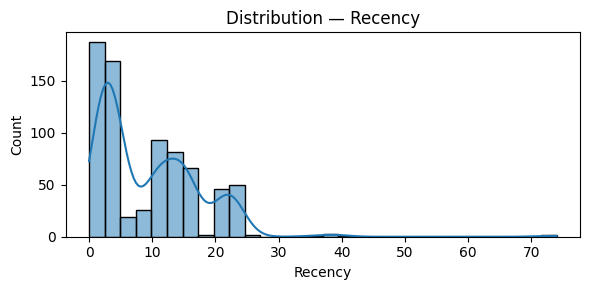

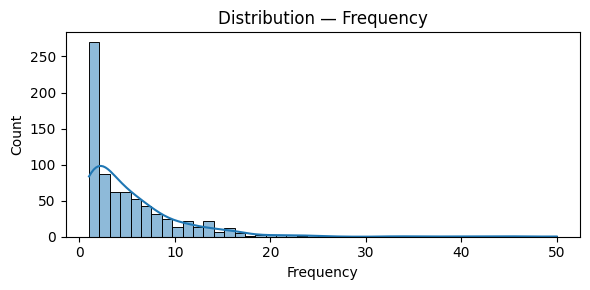

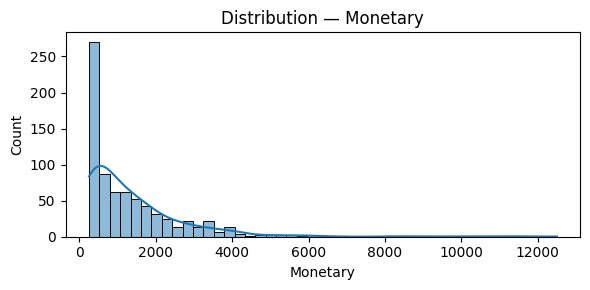

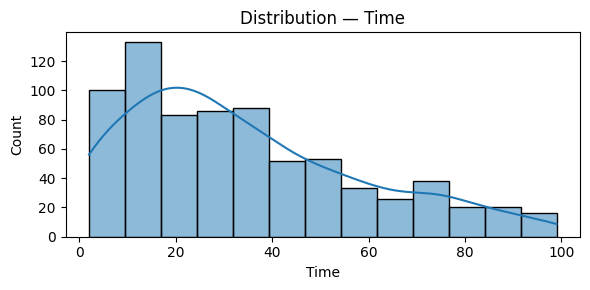

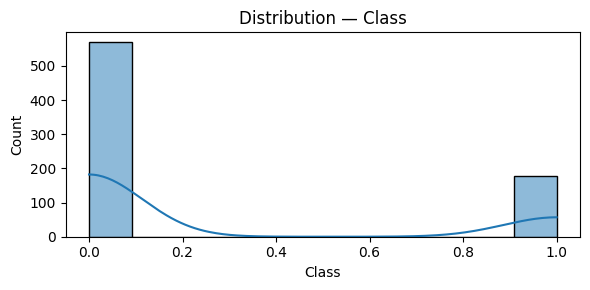

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) numeric distributions
for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c], kde=True)
    plt.title(f"Distribution — {c}")
    plt.tight_layout()
    plt.show()

# 2) categorical counts (top 6)
for c in cat_cols:
    plt.figure(figsize=(6,3))
    df[c].value_counts().nlargest(6).plot(kind='bar')
    plt.title(f"Counts — {c}")
    plt.tight_layout()
    plt.show()

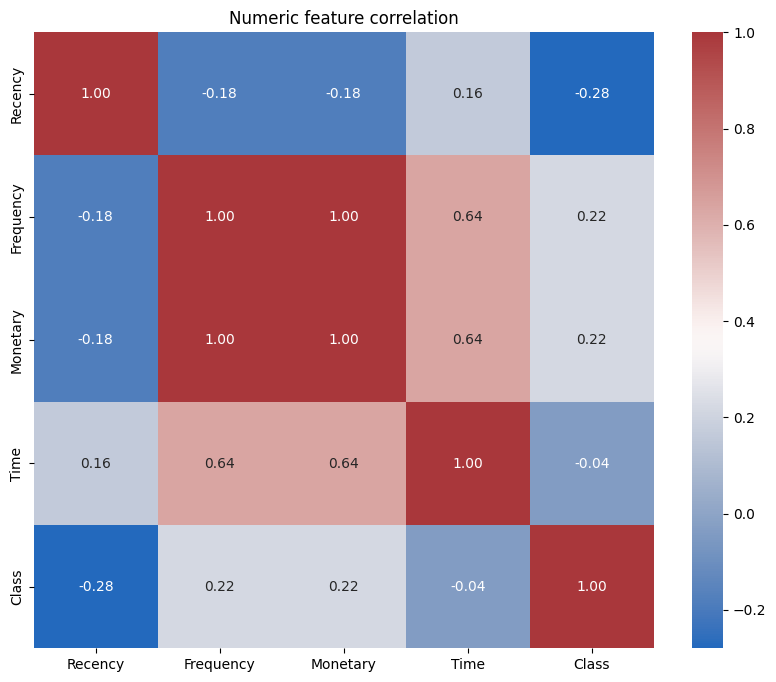

In [10]:
# Correlation matrix (numeric) to spot related features
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Numeric feature correlation")
plt.show()

# Decide target column automatically (or set it manually)

In [11]:
# common target names to look for
candidates = ['target','Target','label','Label','Outcome','outcome','diagnosis','Diagnosis','result','Result']
target_col = None
for t in candidates:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    # fallback: use last column (change this if you know the real target)
    target_col = df.columns[-1]
    print("No obvious target column found. Using last column as target:", target_col)
else:
    print("Using detected target column:", target_col)

# check target type
print("Target dtype:", df[target_col].dtype)
print("Target unique values:\n", df[target_col].value_counts())

No obvious target column found. Using last column as target: Class
Target dtype: int64
Target unique values:
 Class
0    570
1    178
Name: count, dtype: int64


# Encode categorical features & target

In [12]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=[target_col])
y = df[target_col].copy()

# encode categorical features with get_dummies (simple)
X = pd.get_dummies(X, drop_first=True)

# if target is categorical, encode it
if y.dtype.name in ['category','object'] or y.nunique() <= 10:
    le = LabelEncoder()
    y = le.fit_transform(y)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (748, 4) y shape: (748,)


# Train / Test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(set(y))>1 else None
)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (598, 4) (150, 4)


# Baseline model — Random Forest (easy and robust)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.74

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       114
           1       0.45      0.36      0.40        36

    accuracy                           0.74       150
   macro avg       0.63      0.61      0.62       150
weighted avg       0.72      0.74      0.73       150


Confusion matrix:
 [[98 16]
 [23 13]]


# Feature importance — see what **matters**

Top 15 features:
 Time         0.440400
Recency      0.266563
Frequency    0.150673
Monetary     0.142363
dtype: float64


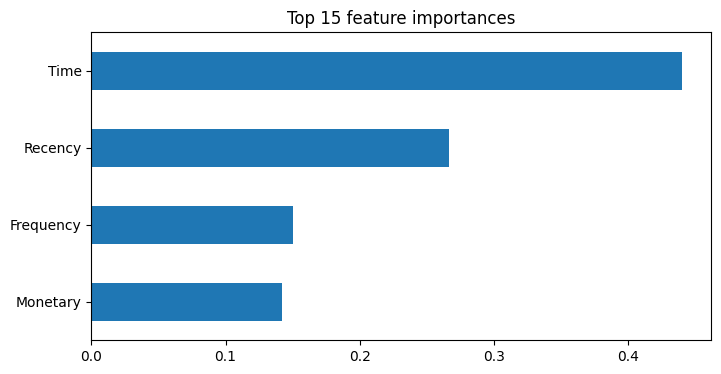

In [15]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 features:\n", importances.head(15))
# quick barplot
plt.figure(figsize=(8,4))
importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 feature importances")
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Adjust these to your actual columns in X_train
num_feats = ['Recency','Frequency','Monetary','Time']
cat_feats = [] # X_train does not have categorical columns in this dataset

num_pipe = Pipeline([('scaler', StandardScaler())])

# Only include a categorical pipeline if cat_feats is not empty
if cat_feats:
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cat_feats)
    ])
else:
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_feats)
    ])

model_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Recency', 'Frequency',
                                                   'Monetary', 'Time'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [None, 5,10,20],
    'clf__min_samples_split': [2,5,10]
}

search = RandomizedSearchCV(model_pipeline, param_dist, n_iter=8, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

Best params: {'clf__n_estimators': 50, 'clf__min_samples_split': 5, 'clf__max_depth': 5}
CV best score: 0.5944001343572729


In [18]:
# after you have a trained pipeline (model_pipeline or search.best_estimator_)
def generate_recommendation(df_patient_row):
    pred = model_pipeline.predict(df_patient_row)
    # tailor mapping to your labels
    mapping = {0: 'No action needed', 1: 'Regular check-up', 2: 'Lifestyle changes', 3: 'Refer to specialist'}
    return mapping.get(int(pred[0]), 'Unknown')

# example usage:
# example_row = X_test.iloc[[0]]  # keep it as DataFrame
# print(generate_recommendation(example_row))

In [19]:
import joblib
joblib.dump(model_pipeline, "health_reco_pipeline.joblib")

['health_reco_pipeline.joblib']